In [13]:
from __future__ import print_function, division
import os
import torch
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms, utils
from pathlib import Path
from PIL import Image
import torchvision.utils as vutils
from torchvision import datasets, models, transforms
import torch.nn as nn
import torch.optim as optim
import time
from tqdm.notebook import tqdm
import math
from sklearn.metrics import accuracy_score
from skimage import io

In [14]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
device

device(type='cuda')

In [15]:
#from fastai code
def top_k_accuracy(input, targs, k=3):
    "Computes the Top-k accuracy (target is in the top k predictions)."
    input = input.topk(k=k, dim=-1)[1]
    targs = targs.unsqueeze(dim=-1).expand_as(input)
    return (input == targs).max(dim=-1)[0].float().mean()

In [16]:
image_size = 224
std,mean = [0.229, 0.224, 0.225],[0.485, 0.456, 0.406] # pretrained models used these values


train_transform = transforms.Compose([
    transforms.RandomResizedCrop(image_size),
    transforms.RandomHorizontalFlip(),
    transforms.ToTensor(),
    transforms.Normalize(mean=mean,
                         std=std)
    ])

test_transform = transforms.Compose([
    transforms.Resize(256),
    transforms.CenterCrop(224),
    transforms.ToTensor(),
    transforms.Normalize(mean=mean,
                         std=std)
])

In [17]:
def my_imshow(img, title='', std=std, mean=mean):
    img = img.permute(1,2,0).cpu()
    img = img * torch.tensor(std) + torch.tensor(mean)
    img = np.clip(img, 0, 1)
    plt.figure (figsize = (16, 16))
    plt.imshow(img)
    plt.title(title)

In [18]:
class IFoodDataset(Dataset):
    def __init__(self, labels_csv, data_path, transforms):
        self.labels_df = pd.read_csv(labels_csv)
        self.data_path = root_path / data_path
        self.compose = transforms
    def __len__(self):
        return len(self.labels_df)
    
    def __getitem__(self, idx):
        img_name = self.data_path/self.labels_df.iloc[idx, 0]
        image = io.imread(img_name)
        image = Image.fromarray(image)
        image = self.compose(image)
        return {'image':image,'label':self.labels_df.iloc[idx, 1]}

In [19]:
bs=128
root_path = Path.cwd() / 'ifood' 
train_labels_csv = 'train_labels.csv'
train_data_path = 'train_set'
train_dataset = IFoodDataset(root_path/train_labels_csv, root_path/train_data_path, train_transform)
train_dataloader = torch.utils.data.DataLoader(train_dataset, batch_size=bs, shuffle=True,num_workers=4)
val_labels_csv = 'val_labels.csv'
val_data_path = 'val_set'
val_dataset = IFoodDataset(root_path/val_labels_csv, root_path/val_data_path, test_transform)
val_dataloader = torch.utils.data.DataLoader(val_dataset, batch_size=bs, shuffle=True,num_workers=4)

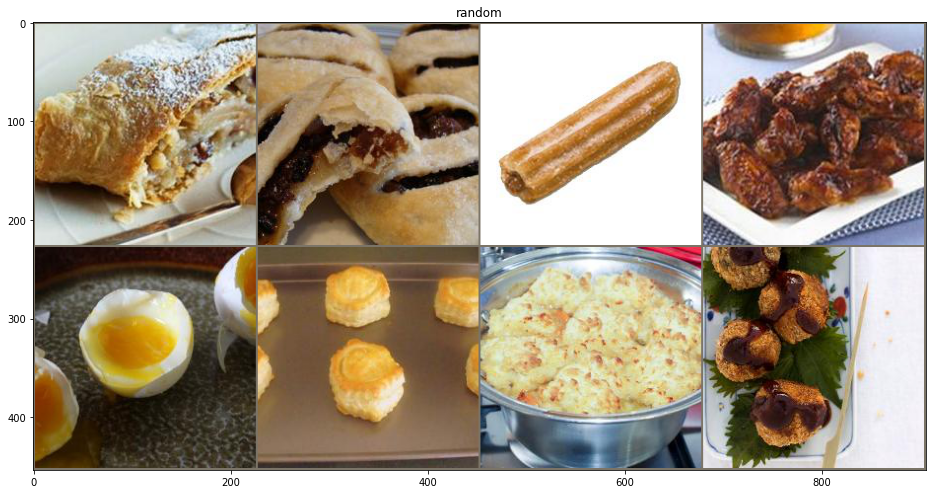

In [20]:
batch = next(iter(val_dataloader))
my_imshow(vutils.make_grid(batch['image'][:8], nrow=4, padding=2), 'random')

In [21]:
# fit/test functions
def fit(iterator, model, optimizer, criterion):
    train_loss = 0
    model.train()
    all_y = []
    all_y_hat = []
    for batch in tqdm(iterator,leave=False):
        optimizer.zero_grad()
        y_hat = model(batch['image'].to(device))
        loss = criterion(y_hat, batch['label'].to(device))
        train_loss += loss.item()*batch['image'].shape[0]
        loss.backward()
        optimizer.step()
        all_y.append(batch['label'])
        all_y_hat.append(y_hat)
    y = torch.cat(all_y,dim=0)
    y_hat = torch.cat(all_y_hat,dim=0)
    acc = top_k_accuracy(y_hat.cpu(),y.cpu())
    return train_loss / len(iterator.dataset),acc

def test(iterator, model, criterion):
    train_loss = 0
    model.eval()
    all_y = []
    all_y_hat = []    
    for batch in tqdm(iterator,leave=True):                    
        with torch.no_grad():
            y_hat = model(batch['image'].to(device))
        loss = criterion(y_hat, batch['label'].to(device))
        train_loss += loss.item()*batch['image'].shape[0]
        all_y.append(batch['label'])
        all_y_hat.append(y_hat)
    y = torch.cat(all_y,dim=0)
    y_hat = torch.cat(all_y_hat,dim=0)
    acc = top_k_accuracy(y_hat.cpu(),y.cpu())
    
    return train_loss / len(iterator.dataset),acc

In [22]:
def train_n_epochs(model, n, optimizer, train_dataloader, val_dataloader):
    criterion = nn.CrossEntropyLoss().to(device)
    for epoch in range(n):
        start_time = time.time()
        train_loss,train_acc = fit(train_dataloader, model, optimizer, criterion)
        valid_loss,valid_acc = test(val_dataloader, model, criterion)
        secs = int(time.time() - start_time)
        print(f'epoch {epoch}. time: {secs}[s]')
        print(f'\ttrain loss: {train_loss:.4f} accuracy: {train_acc:.4f}')
        print(f'\tvalidation loss: {valid_loss:.4f} accuracy: {valid_acc:.4f}')

In [23]:
model = models.resnet34(pretrained=True)
num_ftrs = model.fc.in_features
model.fc = nn.Linear(num_ftrs, 251)
nn.init.kaiming_normal_(model.fc.weight)
nn.init.zeros_(model.fc.bias)
model = model.to(device)
model = nn.DataParallel(model).to(device)

In [24]:
wd=1e-6
lr=1e-4
epochs=10
optimizer = optim.Adam(model.module.parameters(), lr=lr, weight_decay=wd)
train_n_epochs(model,epochs,optimizer, train_dataloader, val_dataloader)


epoch 0. time: 437[s]
	train loss: 3.6043 accuracy: 0.4129
	validation loss: 2.1470 accuracy: 0.6917



epoch 1. time: 423[s]
	train loss: 2.7277 accuracy: 0.5779
	validation loss: 1.8228 accuracy: 0.7467



epoch 2. time: 423[s]
	train loss: 2.4796 accuracy: 0.6232
	validation loss: 1.6645 accuracy: 0.7753



epoch 3. time: 427[s]
	train loss: 2.3232 accuracy: 0.6516
	validation loss: 1.6219 accuracy: 0.7861



epoch 4. time: 423[s]
	train loss: 2.2185 accuracy: 0.6712
	validation loss: 1.5881 accuracy: 0.7861



epoch 5. time: 424[s]
	train loss: 2.1239 accuracy: 0.6876
	validation loss: 1.5754 accuracy: 0.7917



epoch 6. time: 424[s]
	train loss: 2.0411 accuracy: 0.7037
	validation loss: 1.5212 accuracy: 0.8017



epoch 7. time: 425[s]
	train loss: 1.9771 accuracy: 0.7143
	validation loss: 1.5046 accuracy: 0.8048



epoch 8. time: 426[s]
	train loss: 1.9230 accuracy: 0.7230
	validation loss: 1.4581 accuracy: 0.8085



epoch 9. time: 426[s]
	train loss: 1.8631 accuracy: 0.7344
	validation loss: 1.4603 accuracy: 0.8122


In [25]:
torch.save(model.module.state_dict(), 'model.pt')

In [26]:
wd=1e-6
lr=1e-5
epochs=5
for param in model.parameters():
    param.requires_grad = True
optimizer = optim.Adam(model.module.parameters(), lr=lr, weight_decay=wd)
train_n_epochs(model,epochs,optimizer, train_dataloader, val_dataloader)


epoch 0. time: 429[s]
	train loss: 1.6415 accuracy: 0.7721
	validation loss: 1.3040 accuracy: 0.8368



epoch 1. time: 431[s]
	train loss: 1.5659 accuracy: 0.7849
	validation loss: 1.3033 accuracy: 0.8368



epoch 2. time: 429[s]
	train loss: 1.5337 accuracy: 0.7900
	validation loss: 1.2894 accuracy: 0.8392



epoch 3. time: 425[s]
	train loss: 1.5116 accuracy: 0.7931
	validation loss: 1.2904 accuracy: 0.8383



epoch 4. time: 426[s]
	train loss: 1.4892 accuracy: 0.7988
	validation loss: 1.2890 accuracy: 0.8394


In [27]:
wd=1e-6
lr=5e-6
epochs=5
for param in model.parameters():
    param.requires_grad = True
optimizer = optim.Adam(model.module.parameters(), lr=lr, weight_decay=wd)
train_n_epochs(model,epochs,optimizer, train_dataloader, val_dataloader)


epoch 0. time: 427[s]
	train loss: 1.4665 accuracy: 0.8015
	validation loss: 1.2798 accuracy: 0.8391



epoch 1. time: 426[s]
	train loss: 1.4566 accuracy: 0.8031
	validation loss: 1.2937 accuracy: 0.8377



epoch 2. time: 425[s]
	train loss: 1.4418 accuracy: 0.8059
	validation loss: 1.2779 accuracy: 0.8412



epoch 3. time: 427[s]
	train loss: 1.4347 accuracy: 0.8073
	validation loss: 1.2780 accuracy: 0.8387



epoch 4. time: 434[s]
	train loss: 1.4307 accuracy: 0.8084
	validation loss: 1.2846 accuracy: 0.8390


In [28]:
torch.save(model.module.state_dict(), 'model.pt')

## create kaggle submission

In [13]:
# Custom dataset with file name https://gist.github.com/andrewjong/6b02ff237533b3b2c554701fb53d5c4d
class ImageFolderWithPaths(datasets.ImageFolder):
    def __getitem__(self, index):
        original_tuple = super(ImageFolderWithPaths, self).__getitem__(index)
        path = self.imgs[index][0]
        tuple_with_path = (original_tuple + (path,))
        return tuple_with_path

In [14]:
test_dataset = ImageFolderWithPaths((root_path/'test_set/').as_posix(),test_transform)
test_dataloader = torch.utils.data.DataLoader(test_dataset, batch_size=bs, shuffle=False,num_workers=4)

In [15]:
model = models.resnet34(pretrained=False)
num_ftrs = model.fc.in_features
model.fc = nn.Linear(num_ftrs, 251)
model = model.to(device)
model = nn.DataParallel(model).to(device)

model.module.load_state_dict(torch.load('model.pt'))
model.eval()

DataParallel(
  (module): ResNet(
    (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
    (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (relu): ReLU(inplace=True)
    (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
    (layer1): Sequential(
      (0): BasicBlock(
        (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (relu): ReLU(inplace=True)
        (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      )
      (1): BasicBlock(
        (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track

In [16]:
results = torch.tensor([]).long()
paths=()
model.eval()
for batch in tqdm(test_dataloader,leave=False):                    
    with torch.no_grad():
        y_hat = model(batch[0].to(device)).topk(3).indices.cpu()
    paths=paths+batch[2]
    results=torch.cat([results,y_hat],dim=0)  

In [17]:
result_df = pd.DataFrame(results.tolist())
result_df['path']=pd.DataFrame(paths)
result_df['img_name']=result_df['path'].apply(lambda x: x.split('/')[-1])
result_df['label']=result_df.apply(lambda row:f'{row[0]} {row[1]} {row[2]}',axis=1)
result_df[['img_name','label']].to_csv('submission.csv',index=False)
result_df

,0,1,2,path,img_name,label
0,58,7,98,/home/yonatang/deepfood/notebooks/ifood/test_s...,test_000000.jpg,58 7 98
1,25,16,71,/home/yonatang/deepfood/notebooks/ifood/test_s...,test_000001.jpg,25 16 71
2,88,133,156,/home/yonatang/deepfood/notebooks/ifood/test_s...,test_000002.jpg,88 133 156
3,117,104,37,/home/yonatang/deepfood/notebooks/ifood/test_s...,test_000003.jpg,117 104 37
4,51,232,106,/home/yonatang/deepfood/notebooks/ifood/test_s...,test_000004.jpg,51 232 106
...,...,...,...,...,...,...
28372,1,220,156,/home/yonatang/deepfood/notebooks/ifood/test_s...,test_028394.jpg,1 220 156
28373,232,117,175,/home/yonatang/deepfood/notebooks/ifood/test_s...,test_028395.jpg,232 117 175
28374,107,234,209,/home/yonatang/deepfood/notebooks/ifood/test_s...,test_028396.jpg,107 234 209
28375,244,202,160,/home/yonatang/deepfood/notebooks/ifood/test_s...,test_028397.jpg,244 202 160


In [18]:
!kaggle competitions submit -c ifood-2019-fgvc6 -f submission.csv -m "validation submission"

100%|█████████████████████████████████████████| 740k/740k [00:02<00:00, 284kB/s]
Successfully submitted to iFood - 2019 at FGVC6